# Training a CNN + FNO on the Shallow Water equations on 2D plane


### Initialize

In [92]:
save_plots = 0
save_results = 0
n_epochs_FNO = 50
seq_length = 50
batch_size = 16

Nx = 64
tend = 5

### Load packages

In [67]:
import time
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR
import torch.nn.functional as F

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.models import SFNO
from neuralop import LpLoss, H1Loss

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

#from tabulate import tabulate
import time

from utils import *
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Functions

In [68]:
def prepare_data_2D(h_all, p_train, p_val):
    h_all = np.real(h_all)

    # Input a
    a = h_all[:-1]

    # Target u (one time step after a)
    u = h_all[1:]
    n = len(h_all)

    # Split data into training, validation and test sets
    n_train = int(p_train * n)
    n_val = int(p_val * n)
    n_test = n - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    train_x = torch.tensor(a[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, 3, 256)
    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, 3, 256)

    train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, ...)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, ...)

    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y


### Plot initial condition

In [93]:
# Construct the file path 
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}_constant_dt.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(key)
    
    Q_all = f['Q_all'][:]
    t_all = f['t_all'][:]
    x = f['x'][:]
    y = f['y'][:]

print(f'Loaded Q_all with shape {Q_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded x with shape {x.shape}')
print(f'Loaded y with shape {y.shape}')

h_all = Q_all[:, 0, :, :]

## Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D(h_all, p_train, p_val)

Q_all
t_all
x
y
Loaded Q_all with shape (201, 3, 64, 64)
Loaded t_all with shape (201,)
Loaded x with shape (64,)
Loaded y with shape (64,)
n_train = 120, n_val = 40, n_test = 41
torch.Size([120, 64, 64]) torch.Size([120, 64, 64]) torch.Size([40, 64, 64]) torch.Size([40, 64, 64]) torch.Size([40, 64, 64]) torch.Size([40, 64, 64])


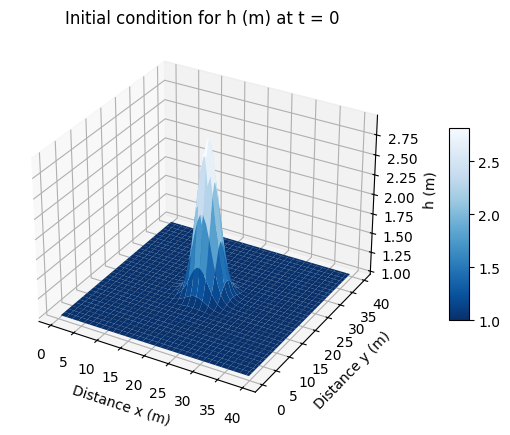

In [94]:
cmap = 'Blues_r'
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, h_all[0], cmap = cmap)
ax.set_title('Initial condition for h (m) at t = 0')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
ax.set_zlabel('h (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

if 0:
    plt.savefig('plots/2D_gauss_initial_condition.pdf', format='pdf')

plt.show()

# FNO

### Prepare data

In [95]:
## Split the data into training and testing
p_train = 1
p_val = 0
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D(h_all, p_train, p_val)

n_train = 201, n_val = 0, n_test = 0
torch.Size([200, 64, 64]) torch.Size([200, 64, 64]) torch.Size([0, 64, 64]) torch.Size([0, 64, 64]) torch.Size([0, 64, 64]) torch.Size([0, 64, 64])


In [96]:
# Prepare data in sequences
def prepare_data_sequences_2D_FNO(train_x, train_y, seq_length):
    # Fetch the dimensions of the input data
    timesteps,_ , spatial_steps_x, spatial_steps_y = train_x.shape
    #print(f"timesteps = {timesteps}, spatial_steps_x = {spatial_steps_x}, spatial_steps_y = {spatial_steps_y}")

    # Number of sequences
    n_sequences = timesteps - seq_length

    # Prepare input and target sequences
    x_seq = torch.zeros((n_sequences, seq_length, 1, spatial_steps_x, spatial_steps_y))
    y_seq = torch.zeros((n_sequences, 1, spatial_steps_x, spatial_steps_y))

    for i in range(n_sequences):
        x_seq[i] = train_x[i:i + seq_length]
        y_seq[i] = train_y[i + seq_length]
    return x_seq, y_seq

In [97]:
# Prepare data in sequences
X_input_train, X_output_train = prepare_data_sequences_2D(train_x, train_y, seq_length)
print(X_input_train.shape, X_output_train.shape)

train_dataset = torch.utils.data.TensorDataset(X_input_train, X_output_train)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

X_output_train.shape

torch.Size([150, 50, 64, 64]) torch.Size([150, 64, 64])


torch.Size([150, 64, 64])

### Define model

In [74]:
# Define model
model = TFNO(
    n_modes=(12,12), # (8,8)
    in_channels=seq_length, # seq_length
    lifting_channels=24, # 32 
    hidden_channels=24, 
    projection_channels=24, 
    out_channels=1, 
    non_linearity = torch.nn.functional.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')


The model has 402681 parameters.


### Train the model

In [75]:
learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-4)

loss_train = []
loss_val = []

model.to(device)

# Time training
start = time.time()

# Training loop
n_epochs = n_epochs_FNO
for epoch in range(n_epochs):
    model.train() # Set model to training mode
    epoch_train_loss = 0

    for batch_X, batch_y in dataloader_train:
        # To device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions.squeeze(), batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0) # Accumulate loss

    # Average loss
    epoch_train_loss /= len(dataloader_train.dataset)

    # Save losses
    loss_train.append(epoch_train_loss)

    # Print losses
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}: Train loss = {epoch_train_loss:.6f}")

# Time training
end = time.time()
training_time = end - start
print(f"Training time: {training_time:.2f}s")

Epoch 0/50: Train loss = 0.608602
Epoch 10/50: Train loss = 0.009313
Epoch 20/50: Train loss = 0.007118
Epoch 30/50: Train loss = 0.003287
Epoch 40/50: Train loss = 0.000715
Training time: 177.65s


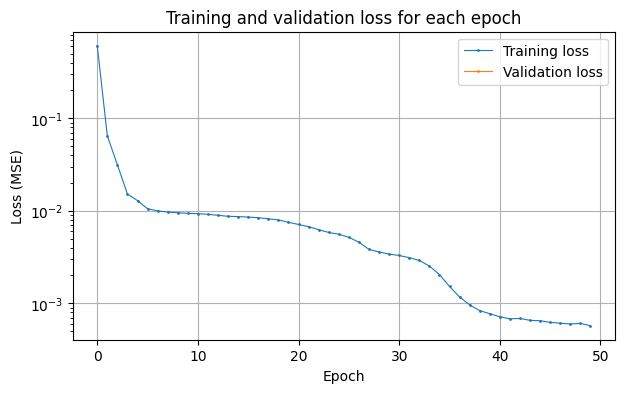

In [76]:
filename = 'plots/2D_FNO_loss.pdf'
plot_losses(loss_train, loss_val, save_plots, filename)

### Make predictions

In [98]:
pred_train = model(X_input_train).cpu().detach().numpy().squeeze()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train], axis=0)
print(pred_all.shape)

# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), X_output_train).item()
print(f"Train loss: {train_loss:.2e}")

# Calculate MAE
loss_new = nn.L1Loss()
train_loss = loss_new(torch.tensor(pred_train), X_output_train).item()
print(f"Train loss: {train_loss:.2e}")

(150, 64, 64)
Train loss: 5.88e-04
Train loss: 1.66e-02


In [109]:
# Define how many time steps to predict
n_steps = 50

# Initialize 
current_state = X_input_train

# Store future predictions
future_predictions = []

# Predict n_steps into the future
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient tracking
    for i in range(n_steps):
        # Predict next time step
        next_state = model(current_state)

        # Store prediction
        future_predictions.append(next_state)

        # Use the predicted state as input for the next prediction
        current_state = torch.cat([current_state[:, 1:], next_state], axis=1)

        if i % 10 == 0:
            print(f"Predicted {i} steps into the future")

# Combine predictions into a single array
print(len(future_predictions))

Predicted 0 steps into the future
Predicted 10 steps into the future
Predicted 20 steps into the future
Predicted 30 steps into the future
Predicted 40 steps into the future
50


### Make predictions for another grid size (a finer grid)

In [85]:
N_pred = 128

# Construct the file path 
file_path = rf'C:\Users\Matteo\Documents\Speciale\Data/toro2D_N={N_pred}_t={tend}_constant_dt.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(key)
    
    Q_all = f['Q_all'][:]
    t_all = f['t_all'][:]
    x = f['x'][:]
    y = f['y'][:]

print(f'Loaded Q_all with shape {Q_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded x with shape {x.shape}')
print(f'Loaded y with shape {y.shape}')

h_all = Q_all[:, 0, :, :]

## Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D(h_all, p_train, p_val)

# Prepare data in sequences
X_input_train, X_output_train = prepare_data_sequences_2D(train_x, train_y, seq_length)
print(X_input_train.shape, X_output_train.shape)

train_dataset = torch.utils.data.TensorDataset(X_input_train, X_output_train)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

X_output_train.shape

pred_train = model(X_input_train).cpu().detach().numpy().squeeze()
pred_all = np.concatenate([pred_train], axis=0)
print(pred_all.shape)

# Define how many time steps to predict
n_steps = 20

# Initialize 
#current_state = torch.tensor(u, dtype=torch.float32)
current_state = X_input_train

# Store future predictions
future_predictions = []

# Predict n_steps into the future
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient tracking
    for i in range(n_steps):
        # Predict next time step
        next_state = model(current_state)

        # Store prediction
        future_predictions.append(next_state)

        # Use the predicted state as input for the next prediction
        current_state = torch.cat([current_state[:, 1:], next_state], axis=1)

        if i % 10 == 0:
            print(f"Predicted {i} steps into the future")

# Combine predictions into a single array
print(len(future_predictions))

Q_all
t_all
x
y
Loaded Q_all with shape (401, 3, 128, 128)
Loaded t_all with shape (401,)
Loaded x with shape (128,)
Loaded y with shape (128,)
n_train = 240, n_val = 80, n_test = 81
torch.Size([240, 128, 128]) torch.Size([240, 128, 128]) torch.Size([80, 128, 128]) torch.Size([80, 128, 128]) torch.Size([80, 128, 128]) torch.Size([80, 128, 128])
torch.Size([190, 50, 128, 128]) torch.Size([190, 128, 128])
(190, 128, 128)
Predicted 0 steps into the future
Predicted 10 steps into the future
20


### Load true solution

In [100]:
# Load data - true solution
Nx = 64
tend = 10 
# Construct the file path 
if Nx == 128:
    file_path = rf'C:\Users\Matteo\Documents\Speciale\Data/toro2D_N={N_pred}_t={tend}_constant_dt.h5'
else:
    file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}_constant_dt.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    Q_all_true = f['Q_all'][:]
    t_all_true = f['t_all'][:]
    x_true = f['x'][:]
    y_true = f['y'][:]

print(f'Loaded Q_all with shape {Q_all_true.shape}')
print(f'Loaded t_all with shape {t_all_true.shape}')
print(f'Loaded x with shape {x_true.shape}')
print(f'Loaded y with shape {y_true.shape}')

h_all_true = Q_all_true[:, 0, :, :]
print(f'h_all_true shape: {h_all_true.shape}')

Loaded Q_all with shape (401, 3, 64, 64)
Loaded t_all with shape (401,)
Loaded x with shape (64,)
Loaded y with shape (64,)
h_all_true shape: (401, 64, 64)


### Plot predictions

In [113]:
save_plots = 1
N_pred = 64

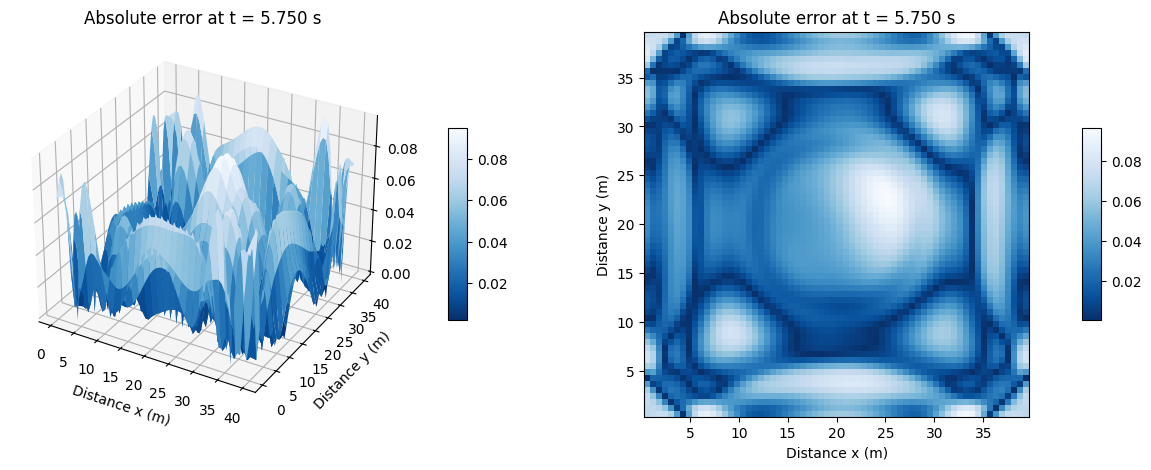

In [114]:
dt = t_all_true[1] - t_all_true[0]
X, Y = np.meshgrid(x, y)
idx = 30
idx_true = 200 + idx
cmap = 'Blues_r'

# Plot errors
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, np.abs(h_all_true[idx_true] - future_predictions[idx][-1].reshape(Nx, Nx).detach().numpy()), cmap=cmap)
ax.set_title(f'Absolute error at t = {t_all_true[idx_true]:.3f} s')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax1 = fig.add_subplot(122)
surf = ax1.imshow(np.abs(h_all_true[idx_true] - future_predictions[idx][-1].reshape(Nx, Nx).detach().numpy()), cmap=cmap, extent=(x_true.min(), x_true.max(), y_true.min(), y_true.max()))
ax1.set_title(f'Absolute error at t = {t_all_true[idx_true]:.3f} s')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, pad=0.1)

if save_plots:
    plt.savefig('plots/2D_FNO_long_term_predictions_error.pdf', format='pdf')

plt.show()

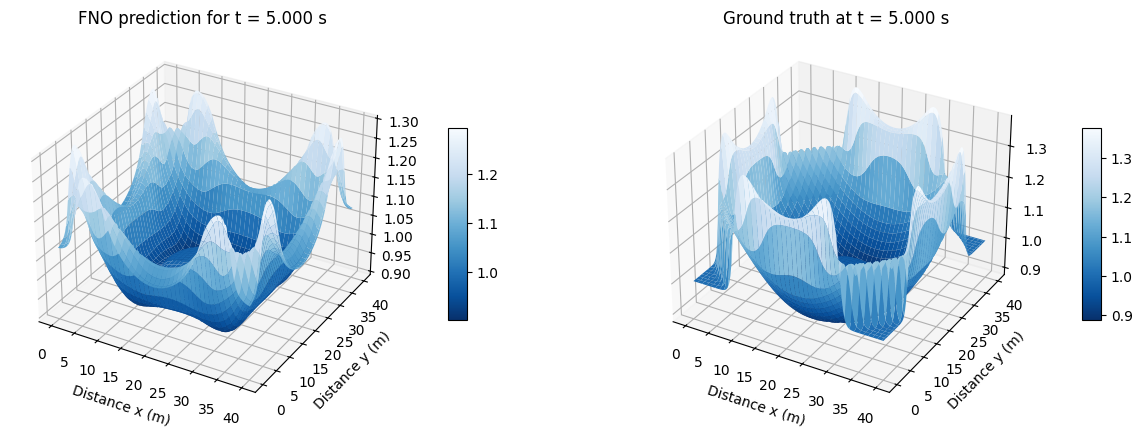

In [89]:
# Plot predictions
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, future_predictions[idx][-1].reshape(Nx, Nx), cmap=cmap)
ax.set_title(f'FNO prediction for t = {t_all_true[idx_true]:.3f} s')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax1 = fig.add_subplot(122, projection='3d')
surf = ax1.plot_surface(X, Y, h_all_true[idx_true], cmap=cmap)
ax1.set_title(f'Ground truth at t = {t_all_true[idx_true]:.3f} s')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, pad=0.1)

if save_plots:
    plt.savefig('plots/2D_FNO_long_term_predictions.pdf', format='pdf')

plt.show()